Задача предсказания стоимости дома в зависимости от характеристик дома

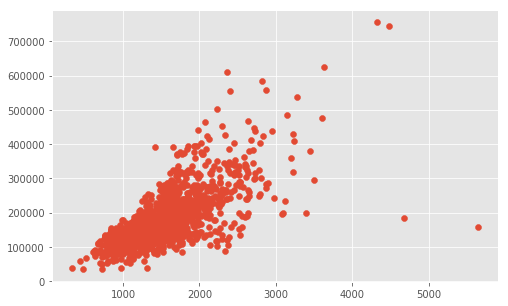

In [12]:
import pandas as pd #предоставляет широкий спектр функций по обработке табличных данных
import numpy as np #содержит реализации многомерных массивов и алгоритмов линейной алгебры. 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression #sklearn реализует множество алгоритмов машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error,  r2_score
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sys import stdout

import math
from scipy import stats

plt.style.use('ggplot')
%matplotlib inline     
#для отображения графиков прямо в юпитере

def rmsle(y_true, y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

filename='C:/Users/kotsi/Downloads/train.csv'
data = pd.read_csv(filename, na_values='nan')
#print(data.info())
plt.figure(figsize=(8,5))
plt.scatter(data['GrLivArea'], data['SalePrice'])

Преподготовка данных

In [13]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if (data[c].dtype.name != 'object')]

#количественные заполним медианным значением            
data = data.fillna(data.median(axis=0), axis=0)
data_describe = data.describe(include=[object])#присваеваем все, где тип object - т.е. категориальные
#категориальные заменяем наиболее частым
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])#fillna -заполнение пустых

#Векторизация(преобразование категориальных в количественные)
#выделяем бинарные, заменяем на 0 и 1
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
for c in binary_columns:
    top = data_describe[c]['top']
    top_items = data[c] == top
    data.loc[top_items, c] = 0
    data.loc[np.logical_not(top_items), c] = 1
    
#обработка небинарных
#Заменяем признаки числом их признаков. 
data_nonbinary = pd.get_dummies(data[nonbinary_columns]) 

#нормализация - приведение всех числовых к диапазону [0,1]
data_numerical=data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
#data_numerical.describe()
data = pd.concat((data_numerical, data[binary_columns], data_nonbinary), axis=1)
data = pd.DataFrame(data, dtype=float)
print (data.shape)#стало 286 фич, а не 81

#важные
'''
OverallQual             0.790982 - Общий материал и качество отделки
GrLivArea               0.708624 - Выше (земля) жилая площадь квадратных футов.
GarageCars              0.640409 - Размер гаража вместимость автомобиля
TotalBsmtSF             0.613581 - Общая площадь квадратных футов.
ExterQual_TA906                  - Качество материала снаружи.
FullBath                0.560664 - Полные ванные комнаты выше класса.
BsmtQual_Ex             0.553105 - Высота фундамента - Отлично (100+ дюймов)
YearBuilt               0.522897 - Оригинальная дата строительства.
KitchenQual_TA          0.519298 - Качество кухни - среднее
GarageFinish_Unf        0.513906 - Внутренняя отделка гаража - незакончена
'''
print(data.corr()['SalePrice'].abs().sort_values(ascending=False).head(15))
data=data[['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','ExterQual_TA',
           'FullBath','BsmtQual_Ex','YearBuilt','KitchenQual_TA','GarageFinish_Unf']]

(1460, 286)
SalePrice           1.000000
OverallQual         0.790982
GrLivArea           0.708624
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
ExterQual_TA        0.589044
FullBath            0.560664
BsmtQual_Ex         0.553105
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
KitchenQual_TA      0.519298
GarageFinish_Unf    0.513906
YearRemodAdd        0.507101
Name: SalePrice, dtype: float64


Разделение данных и обучение модели

In [14]:
X = data.drop('SalePrice', axis='columns') #матрица "объекты-признаки"
y = data['SalePrice'] #вектор ответов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

lr=LinearRegression()
lr.fit(X_train, y_train)
prediction=lr.predict(X_test)
print('Mean_Absolute_Error '+str(mean_absolute_error(y_test,prediction)))
print("RMSE "+str(rmsle(y_test,prediction)))
pca=PCA(n_components=10)
XPCAreduced=pca.fit_transform(X)

Mean_Absolute_Error 0.272778682889739
RMSE 0.5676126632946077


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\tensorflow35\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


Реализация линейной регрессии

In [15]:
import random

def predict_outcome(feature_matrix, weights): 
    weights=np.array(weights) 
    predictions = np.dot(feature_matrix, weights) 
    return predictions 

def errors(output,predictions): 
    errors=predictions-output 
    return errors 

def feature_derivative(errors, feature): 
    derivative=np.dot(2,np.dot(feature,errors)) 
    return derivative 


def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance): 
    converged = False 
#Начальные веса преобразуются в массив numpy 
    weights = np.array(initial_weights) 
    while not converged: 
# вычислить прогнозы на основе feature_matrix и весов: 
        predictions=predict_outcome(feature_matrix,weights) 
# вычислять ошибки как predictions - output: 
        error=errors(output,predictions) 
        gradient_sum_squares = 0 # инициализирование градиента 
# пока не сходится, обновлять каждый вес отдельно: 
        for i in range(len(weights)): 
# Вызов feature_matrix[:, i] если столбец фич связан с весами[i] 
            feature=feature_matrix[:, i] 
            deriv=feature_derivative(error,feature) 
# добавить квадратную производную к величине градиента 
            gradient_sum_squares=gradient_sum_squares+(deriv**2) 
# обновить вес на основе размера шага и производной: 
            weights[i]=weights[i] - np.dot(step_size,deriv) 

        gradient_magnitude = math.sqrt(gradient_sum_squares) 
#stdout.write("\r%d" % int(gradient_magnitude)) 
        stdout.flush() 
        if gradient_magnitude < tolerance: 
            converged = True 
    return(weights) 

simple_feature_matrix = XPCAreduced 
output = y 
for i in range(10):
    nums[i]=random.uniform(0.00001, 0.01)
initial_weights = np.array(nums) 
step_size = 0.0001 
tolerance = 2.5e2 
simple_weights = regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, tolerance) 

hand_y_train_predict = np.dot(X_train, simple_weights) 
hand_y_test_predict = np.dot(X_test, simple_weights) 

print("By hands") 
print("Mean_Absolute_Error: "+str(mean_absolute_error(y_test, hand_y_test_predict))) 
print("RMSE: "+str(rmsle(y_test, hand_y_test_predict)))

NameError: name 'nums' is not defined